In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from uncertainties import ufloat
from uncertainties.umath import * 

# Misc Notes
- Mention if air, argon, or nitrogen and how it can affect the decay
- Gas will increase the lifetime

In [2]:
# create df for data
file = open("positronium decay.txt", "r")
lines = file.readlines()
file.close()
lines = lines[12:16396]
data = [line.strip() for line in lines]

df = pd.DataFrame(data, columns=['Counts'])
df["Time"] = df.index*0.060459 + 6.106410
df["Counts"] = df["Counts"].astype(float)

In [3]:
# bin the data to make it smoother
### play around with bin size to see if it makes a difference in end result ###

bin_size = 10
binned_data = df.groupby(df.index // bin_size).agg({'Time': 'mean', 'Counts': 'sum'}).reset_index(drop=True)

# theres some outlier points which skews the data, remove 
### change to 11 or 12 maybe for shaper peak, which might give a better time
maskoutlier = binned_data["Time"] > 11
binned_data = binned_data[maskoutlier]

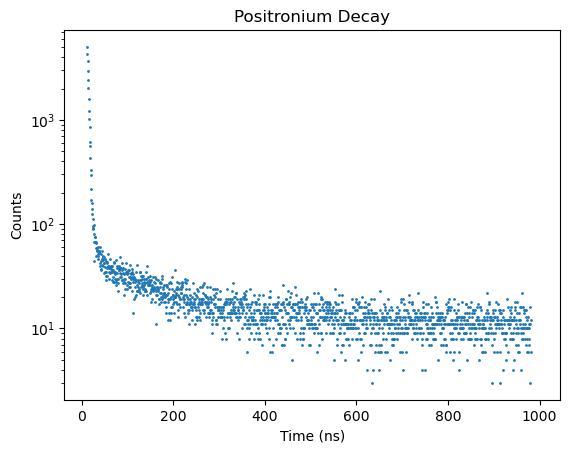

In [4]:
# plot the data on log plot

plt.plot(binned_data["Time"], binned_data["Counts"], "o", markersize=1)
plt.xlabel("Time (ns)")
plt.ylabel("Counts")
plt.title("Positronium Decay")
plt.yscale('log')
plt.show()

### Analysis Method 1: Subtracting the background

Did not work, our data's standard deviation was too high.
- Go to method 2

In [5]:
plt.rcParams.update({'font.size': 14})

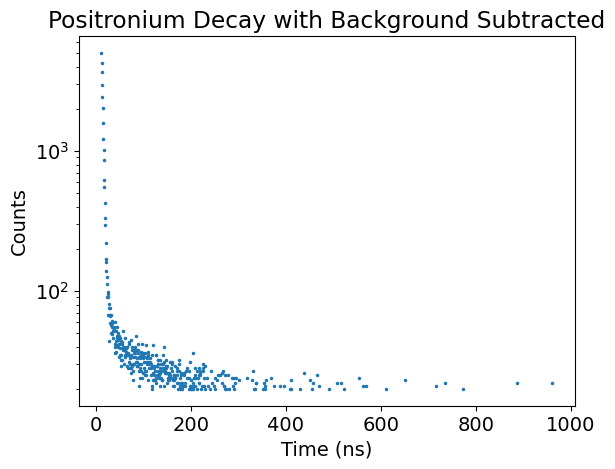

In [6]:
backmask = binned_data["Time"] > 900
back1 = binned_data[backmask]

back1_mean = back1["Counts"].mean()
back1_std = back1["Counts"].std()

subtracted_mask1 = binned_data["Counts"] > back1_mean + 2 * back1_std
subtracted_data1 = binned_data[subtracted_mask1]

plt.plot(subtracted_data1["Time"], subtracted_data1["Counts"], "o", markersize=1.5)
plt.yscale('log')
plt.title("Positronium Decay with Background Subtracted")
plt.xlabel("Time (ns)")
plt.ylabel("Counts")
plt.show()

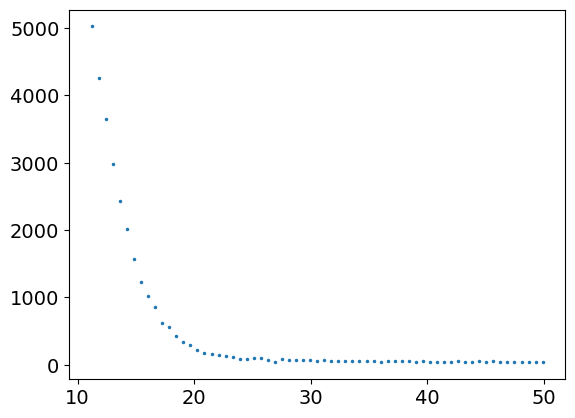

In [7]:
# find the peak of the parapositronium decay

## according to the manual, the choice for the upper bound is slightly arbitrary
# look for what reasonable upper peak

parapeak_mask = subtracted_data1["Time"] < 50
parapeak_data = subtracted_data1[parapeak_mask]

plt.plot(parapeak_data["Time"], parapeak_data["Counts"], "o", markersize=1.5)

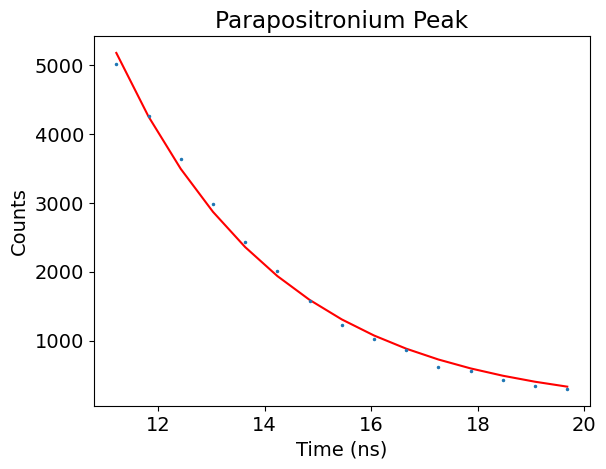

In [8]:
# try like 20 as the upper, even if we don't include relevant data to the right the fit should be the same

def exponential(x, a, b):
    return a * np.exp(-b * x)

parapeak_mask = parapeak_data["Time"] < 20
parapeak_data = parapeak_data[parapeak_mask]

popt, pcov = curve_fit(exponential, parapeak_data["Time"], parapeak_data["Counts"], p0=[1.99118298 * 10**5 , 3.25362009 * 10 ** -1])
plt.plot(parapeak_data["Time"], exponential(parapeak_data["Time"], *popt), 'r-')
plt.plot(parapeak_data["Time"], parapeak_data["Counts"], "o", markersize=1.5)
plt.title("Parapositronium Peak")
plt.xlabel("Time (ns)")
plt.ylabel("Counts")
plt.show()

In [9]:
# values for parapositronium peak

paralamb = ufloat(popt[1], np.sqrt(pcov[1][1]))
halfpara = np.log(2) / paralamb

print("Parapositronium Peak")
print("Lambda (1/ns): ", paralamb)
print("Half Life (ns): ", halfpara)

Parapositronium Peak
Lambda (1/ns):  0.325+/-0.007
Half Life (ns):  2.13+/-0.04


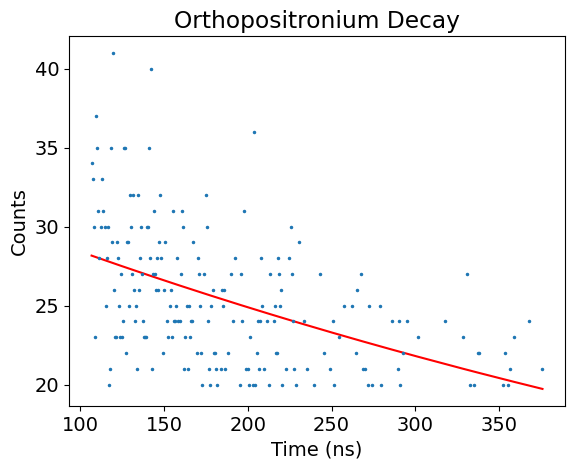

In [10]:
# find the peak of the orthopositronium decay
## according to the manual, the choice for the upper bound is still arbitrary, lets look for 25 lifetimes away
## lets not look for values after 380 ns

ortho_mask = (subtracted_data1["Time"] < 380) & (subtracted_data1["Time"] > 50*halfpara)
ortho_data = subtracted_data1[ortho_mask]

guess = (200, 0.006)
popt, pcov = curve_fit(exponential, ortho_data["Time"], ortho_data["Counts"], p0=guess)

plt.plot(ortho_data["Time"], exponential(ortho_data["Time"], *popt), 'r-')
plt.plot(ortho_data["Time"], ortho_data["Counts"], "o", markersize=1.5)
plt.title("Orthopositronium Decay")
plt.xlabel("Time (ns)")
plt.ylabel("Counts")
plt.show()

In [11]:
# Values of orthopositronium peak

ortholamb = ufloat(popt[1], np.sqrt(pcov[1][1]))
halfortho = np.log(2) / ortholamb

print("Orthopositronium Peak")
print("Lambda (1/ns): ", ortholamb)
print("Half Life (ns): ", halfortho)

Orthopositronium Peak
Lambda (1/ns):  0.00132+/-0.00017
Half Life (ns):  (5.2+/-0.7)e+02


This doesn't look right, and looking over it my analysis doesn't look like method 1 described in the report. I think the standard deviation is too high

# Data Analysis Method 2: Introducing a constant

[3.24418655e+01 1.32427980e-03] [1.99118501e+05 3.25362091e-01]


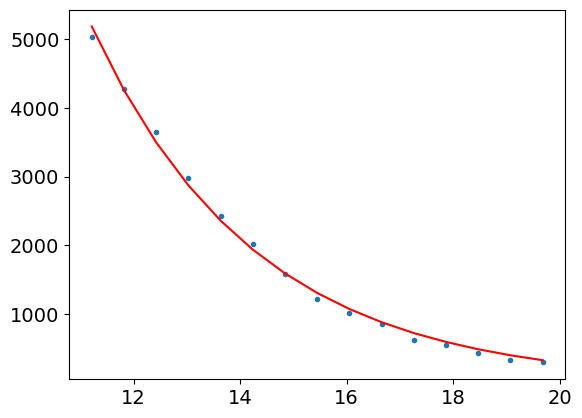

In [12]:
## first find the parapositronium peak again, same as before just don't subtract background yet
# this step isn't really needed

parapeak_mask = binned_data["Time"] < 20
parapeak_data = binned_data[parapeak_mask]

plt.plot(parapeak_data["Time"], parapeak_data["Counts"], "o", markersize=3)

guess = [10000, 0.1, 0]
poptpara, pcov2 = curve_fit(exponential , parapeak_data["Time"], parapeak_data["Counts"], p0=[1.99118298 * 10**5 , 3.25362009 * 10 ** -1])

plt.plot(parapeak_data["Time"], exponential(parapeak_data["Time"], *poptpara), 'r-')
print(popt, poptpara)

In [13]:
para_lambda = ufloat(poptpara[1], np.sqrt(pcov2[1][1]))
half_para = np.log(2) / para_lambda

print("Parapositronium Peak Method 2")
print("Lambda (1/ns): ", para_lambda)
print("Half Life (ns): ", half_para)

Parapositronium Peak Method 2
Lambda (1/ns):  0.325+/-0.007
Half Life (ns):  2.13+/-0.04


In [14]:
half_para*60

127.82322210170952+/-2.660892918658416

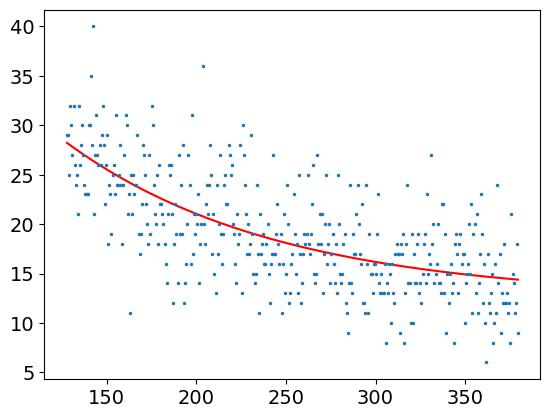

In [15]:
# fit the orthopositronium peak
# introduce a constant term to the fit

def exponential2(x, a, b, c):
    return a * np.exp(-b * x) + c

# Sanni mentioned he got more accurate data if he didn't use some of the data between parapositronium and
# the orthopositronium data, so we'll have a gap between 20 and 30 lifetimes away we don't use

ortho_mask = (binned_data["Time"] < 380) & (binned_data["Time"] > half_para*60)
ortho_data = binned_data[ortho_mask]

guess = (200, 0.006, 15)
poptortho, pcovortho = curve_fit(exponential2, ortho_data["Time"], ortho_data["Counts"], p0=guess)

plt.plot(ortho_data["Time"], exponential2(ortho_data["Time"], *poptortho), 'r-')
plt.plot(ortho_data["Time"], ortho_data["Counts"], "o", markersize=1.5)

In [16]:
# values for orthopositronium peak

ortho_lambda = ufloat(poptortho[1], np.sqrt(pcovortho[1][1]))
half_ortho = np.log(2) / ortho_lambda

print("Orthopositronium Decay")
print("Lambda (1/ns): ", ortho_lambda)
print("Half Life (ns): ", half_ortho)

Orthopositronium Decay
Lambda (1/ns):  0.0085+/-0.0018
Half Life (ns):  82+/-17


# Summary

/var/folders/my/7_s7rmpd2nbftt_ccq3xskj00000gn/T/ipykernel_55396/2603475312.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(parapeak_data["Time"], exponential(parapeak_data["Time"], *poptpara), 'r-', label="Parapositronium Fit", color = "magenta", linewidth =2)
/var/folders/my/7_s7rmpd2nbftt_ccq3xskj00000gn/T/ipykernel_55396/2603475312.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(ortho_data["Time"], exponential2(ortho_data["Time"], *poptortho), 'r-', label="Orthopositronium Fit", color="green", linewidth = 3)


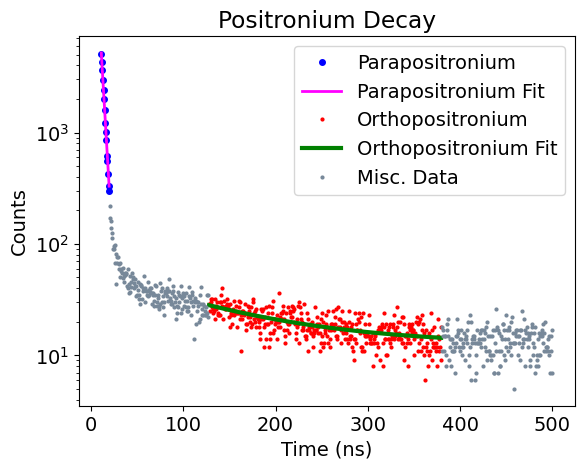

Orthopositronium Decay
Lambda (1/ns):  0.0085+/-0.0018
Half Life (ns):  82+/-17


In [37]:
# plot of parapositronium peak
plt.plot(parapeak_data["Time"], parapeak_data["Counts"], "o", markersize=4, label="Parapositronium", color = "blue")
plt.plot(parapeak_data["Time"], exponential(parapeak_data["Time"], *poptpara), 'r-', label="Parapositronium Fit", color = "magenta", linewidth =2)

# plot of orthopositronium peak
plt.plot(ortho_data["Time"], ortho_data["Counts"], "o", markersize=2, label="Orthopositronium", color = "red")
plt.plot(ortho_data["Time"], exponential2(ortho_data["Time"], *poptortho), 'r-', label="Orthopositronium Fit", color="green", linewidth = 3)

# plot the unused data
mask = (binned_data["Time"] > 20) & (binned_data["Time"] < half_para*60)
unused_data = binned_data[mask]
plt.plot(unused_data["Time"], unused_data["Counts"], "o", markersize=2, label="Misc. Data", color="lightslategray")

mask2 = (binned_data["Time"] > 380) & (binned_data["Time"] < 500)
unused_data2 = binned_data[mask2]
plt.plot(unused_data2["Time"], unused_data2["Counts"], "o", markersize=2, color="lightslategray")

plt.title("Positronium Decay")
plt.xlabel("Time (ns)")
plt.ylabel("Counts")
plt.yscale('log')
plt.legend()
plt.show()

print("Orthopositronium Decay")
print("Lambda (1/ns): ", ortho_lambda)
print("Half Life (ns): ", half_ortho)